In [2]:
import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2


In this section, a demonstration of the MKS homogenization
and localization workflows as shown in Fig. REF are presented
using PyMKS. Additional examples can be found on the PyMKS
website.

# Prediction of Effective Stiffness with Homogenization


## Calibration Data Generation

In this example the `MKSHomogenizationModel` is used to create
a structure-property linkage between a 2-phase composite
material and effective stiffness $C_{xx}$. 

Multiple classes of periodic microstructures and their effective
elastic stiffness values  can be generated by importing
the `make_elastic_stiffness` function from `pymks.datasets`.

This function has several arguments. `n_samples` is a list indicating
the number of microstructures for each class. `grain_size`
and `volume_fraction` are also lists that specify the average grain
features and mean volume fractions for each of the microstructure
classes. Variance in the volume fractions for each class can be
controlled using `percent_variance` which specifies a range of
volume fractions centered about the mean values (i.e.
`volume_fration` $\pm$ `percent_variance`). `size` indicates
the dimensions of all the microstructures. `elastic_modulus` and
`poissons_ratio` are used to indicate the material properties for
each of the phases. Lastly, `seed` is used as the seed for the
random number generator.

In this homogenization example, 50 samples from 16 different
microstructures classes with dimensions 21 x 21 and their effective
stiffness values were created totaling to 800 samples. Each of the
16 classes have different sized microstructure features and
volume fractions. The  `make_elastic_stiffness` function returns
the microstructures `X` and their associated stiffness values `y`.

In [3]:
from pymks.datasets import make_elastic_stiffness
import numpy as np

sample_size = 50
n_samples = [sample_size] * 16

grain_size = [(8, 8), (8, 6), (6, 8), (6, 6),
              (10, 4), (4, 10), (4, 4), (10, 10),
              (12, 2), (2, 12), (2, 2), (12, 12),
              (14, 1), (1, 14), (1, 1), (14, 14)]

volume_fraction = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5),
                   (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5),
                   (0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5),
                   (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5)]

percent_variance = 0.15 
elastic_modulus = (300, 200)
poissons_ratio = (0.28, 0.3)
size = (21, 21)
seed = 1

X, y = make_elastic_stiffness(n_samples=n_samples, 
                              volume_fraction=volume_fraction,
                              grain_size=grain_size,  size=size,
                              percent_variance=percent_variance,
                              elastic_modulus=elastic_modulus, 
                              poissons_ratio=poissons_ratio, seed=seed)


The an example microstructure from each of the 16 classes
can be visualized by importing `draw_microstructures`
function from `pymks.tools`.

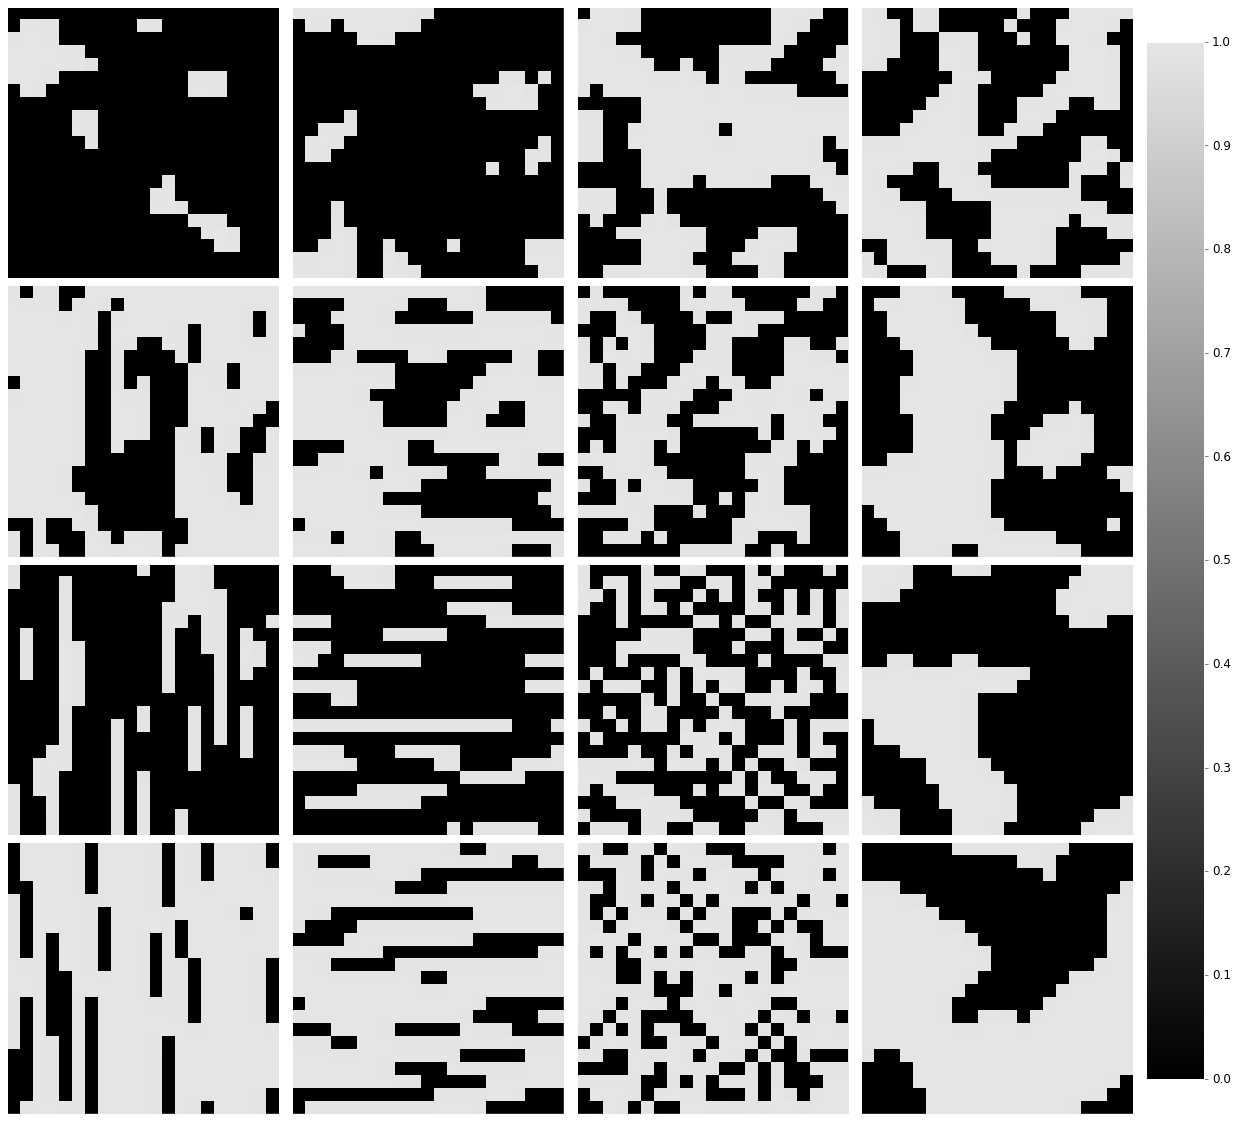

In [4]:
from pymks.tools import draw_microstructures

X_examples = X[1::sample_size]
draw_microstructures(X_examples, figsize=(4, 4))



## Calibration of Homogenization Model

Before an instance of the `MKSHomogenizationModel` can be made,
an instance of a basis class is needed to specify the discretization
method for the microstructure functions (see Fig. [ADD_REF]). For this
particular example, there are only 2 discrete phases numerated by 0
and 1. It has been shown that the primitive basis provides the most
compact representation of discrete phases ADD REF. In PyMKS the class
`PrimitiveBasis` from `pymks.bases` can be used with `n_states` equal
to `2` and the `domain` equal to `[0, 1]`.

In addition to the basis class, the periodic axes as well as the set of
spatial correlations need to be specified for the
`MKSHomogenizationModel`. This is done using the arguments
`periodic_axes` and `correlations` respectively . In practice the set
of spatial correlations are a hyper parameter of our model that could
be optimized, but for this toy example only the two autocorrelations
will be used.

In [5]:
from pymks import MKSHomogenizationModel
from pymks import PrimitiveBasis

prim_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSHomogenizationModel(basis=prim_basis, periodic_axes=[0, 1], 
                              correlations=[(0, 0), (1, 1)])

The default pipeline used to create the homogenization linkage
uses PCA and polynomial regression objects for Scikit-learn.
Using `GridSeachCV` from Scikit-learn, cross validation is
used on the testing data to find the optimal number of principal
components and degree of polynomial (based on the R-squared values)
within a defined subspace for the hyper parameters for our model.
A dictionary `params_to_tune` defines the subspace. For this example
`n_components` will be varied between 1 to 13 and `degree` of the
polynomial regression will be varied between 1 to 3.
`StratifiedKFold` is used to ensure that microstructures from each
of the classes are used for each fold of the cross validation. The
array `labels` is used to label each of the classes.


In [6]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

flat_shape = (X.shape[0],) + (X[0].size,)
params_to_tune = {'degree': np.arange(1, 4),
                  'n_components': np.arange(1, 13)}
labels = np.repeat(np.arange(16), 50)
skf = StratifiedKFold(labels, n_folds=5)

fit_params = {'size': X[0].shape}
gs = GridSearchCV(model, params_to_tune, cv=skf,
                  fit_params=fit_params).fit(X.reshape(flat_shape), y)


The results of our parameter grid search can be explored by either
printing or creating visualizations of the results. The parameters
and score of the best estimator can be printed as shown below.

In [7]:
from __future__ import print_function

print('Order of Polynomial', gs.best_estimator_.degree)
print('Number of Components', gs.best_estimator_.n_components)
print('R-squared Value', gs.score(X, y))


Order of Polynomial 2
Number of Components 11
R-squared Value 0.999960653331


Two different visualizations of the results from `GridsearchCV`
with can be created using  `draw_gridscores_matrix` and
`draw_gridscores` from `pymks.tools`.

`draw_gridscores_matrix` provides a visualization of two
matrices for both the mean R-squared values and their
standard deviation.


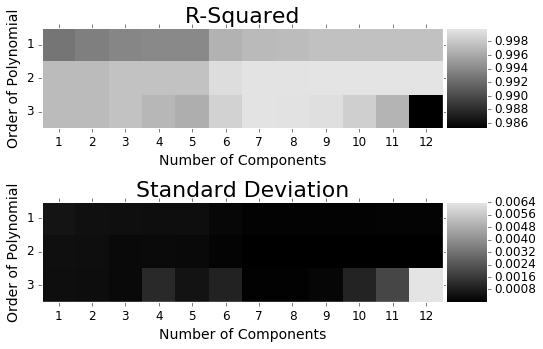

In [8]:
from pymks.tools import draw_gridscores_matrix

draw_gridscores_matrix(gs, ['n_components', 'degree'], score_label='R-Squared',
                       param_labels=['Number of Components', 'Order of Polynomial'])


`draw_gridscores` provides another view of the same information
with the mean values indicated by the points and the standard
deviation indication by the shared regions.

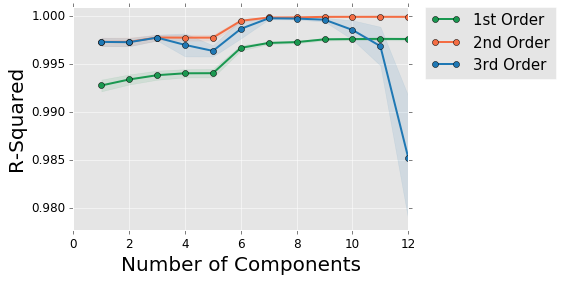

In [9]:
from pymks.tools import draw_gridscores

gs_deg_1 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 1]
gs_deg_2 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 2]
gs_deg_3 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 3]

draw_gridscores([gs_deg_1,  gs_deg_2, gs_deg_3], 'n_components', 
                data_labels=['1st Order', '2nd Order', '3rd Order'],
                param_label='Number of Components', score_label='R-Squared')


For the specified parameter range, the model with the highest
R-squared value was found to have a 2nd order polynomial with 11
principal components. This model is calibrated using the entire
data set and  used for the rest of the example.

In [10]:
model = gs.best_estimator_

model.fit(X, y)

## Prediction using MKSHomogenizationModel

In order to validate our model, additional data is generated
using the `make_elastic_stiffness` function again with the same
parameters with the exception of the number of samples and
the seed used for the random number generator. The function
returns the new microstructure `X_new` and their effective
stiffness values `y_new`.

In [11]:
test_sample_size = 10
n_samples = [test_sample_size] * 16

seed = 0

X_new, y_new = make_elastic_stiffness(n_samples=n_samples, size=size, 
                                      grain_size=grain_size,
                                      volume_fraction=volume_fraction, 
                                      percent_variance=percent_variance,
                                      elastic_modulus=elastic_modulus, 
                                      poissons_ratio=poissons_ratio, 
                                      seed=seed)


Effective stiffness values for the new data are generated using the
`predict` method.


In [12]:
y_pred = model.predict(X_new)


A visualization of the principal component scores for both
the calibration and the validation data can be created using
`draw_components_scatter` from `pymks.tools`. 

Because both the validation and the calibration data were generated
from the `make_elastic_stiffness` function with the same parameters
both sets of data are different samples from the same distribution.
Similar visualizations can provide insights on differences between
different data sources for both calibration and prediction.


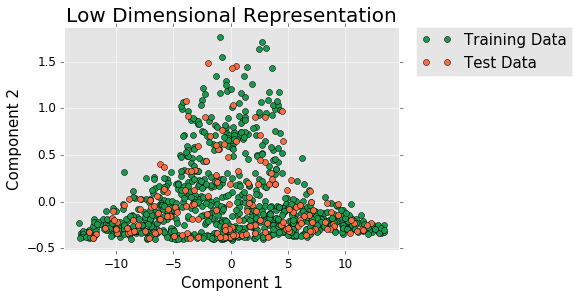

In [13]:
from pymks.tools import draw_components_scatter


draw_components_scatter([model.reduced_fit_data[:, :2], 
                         model.reduced_predict_data[:, :2]],
                        ['Training Data', 'Test Data'],
                        legend_outside=True)


As an evaluation of our model's predictions, a
goodness-of-fit plot can be generated by importing
`draw_goodness_of_fit` from `pymks.tools`. Additionally
the R-squared value for our predicted data can be
printed.

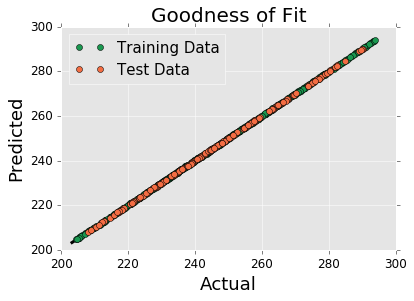

R-squared value 0.999949544961


In [15]:
from pymks.tools import draw_goodness_of_fit


fit_data = np.array([y, model.predict(X)])
pred_data = np.array([y_new, y_pred])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Test Data'])

print('R-squared value', model.score(X_new, y_new))

The `MKSHomogenizationModel` has created a homogenization
linkage between 16 difference microstructure classes
and their effective stiffness values with an R-squared value
of nearly 1.